In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
#@title Loading MNIST dataset
from sklearn.model_selection import train_test_split

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [4]:
#@title Loading MNIST dataset
from sklearn.model_selection import train_test_split

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train)

In [5]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((48000, 28, 28),
 (48000,),
 (12000, 28, 28),
 (12000,),
 (10000, 28, 28),
 (10000,))

In [6]:
#@title Anomaly assignment

def get_dataset(dataset, anomaly_labels):
    anomaly_idxs = np.isin(dataset[1], anomaly_labels)
    return dataset[0][~anomaly_idxs], dataset[1][~anomaly_idxs], dataset[0][anomaly_idxs], dataset[1][anomaly_idxs]


anomaly_labels = [8, 9]

x_train_normal, y_train_normal, x_train_anomaly, y_train_anomaly = get_dataset((x_train, y_train), anomaly_labels)
x_val_normal, y_val_normal, x_val_anomaly, y_val_anomaly = get_dataset((x_val, y_val), anomaly_labels)

In [11]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, Flatten
from tensorflow.keras.layers import Dense, Conv2DTranspose, MaxPooling2D


img_shape = (28, 28, 1)

autoencoder = Sequential([InputLayer(input_shape=img_shape),
                    Conv2D(32, (3, 3), activation="relu", padding="same"),
                    MaxPooling2D((2, 2), padding="same"),
                    Conv2D(32, (3, 3), activation="relu", padding="same"),
                    MaxPooling2D((2, 2), padding="same"), 
                    Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same"), 
                    Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same"), 
                    Conv2D(1, (3, 3), activation="sigmoid", padding="same")])

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 1)        

In [12]:
n_epochs = 100
batch_size = 128

history = autoencoder.fit(x_train_normal, x_train_normal,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(x_val_normal, x_val_normal))


Epoch 1/100


ValueError: in user code:

    /Users/qqq/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:855 train_function  *
        return step_function(self, iterator)
    /Users/qqq/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/qqq/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/qqq/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/qqq/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/qqq/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:838 run_step  **
        outputs = model.train_step(data)
    /Users/qqq/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:795 train_step
        y_pred = self(x, training=True)
    /Users/qqq/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/qqq/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:230 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_2 is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: (None, 28, 28)


In [27]:
# Plot history of loss and validation loss against epoch
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training")
plt.legend()
plt.show()

In [34]:
x_test_normal, y_test_normal, x_test_anomaly, y_test_anomaly = get_dataset((x_test, y_test), anomaly_labels)

In [37]:
decoded_imgs = autoencoder.predict(x_test_normal)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_normal[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [38]:
decoded_imgs = autoencoder.predict(x_test_anomaly)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_anomaly[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [93]:
def compute_reconstruction_error(model, data, similarity_func=lambda x, y: np.linalg.norm(x - y, axis=(1, 2))):
    predicted = model.predict(data)[:, :, :, 0]
    return similarity_func(data, predicted) / data.shape[1]

errors_norm = compute_reconstruction_error(autoencoder, x_val_normal)
errors_anomaly = compute_reconstruction_error(autoencoder, x_val_anomaly)

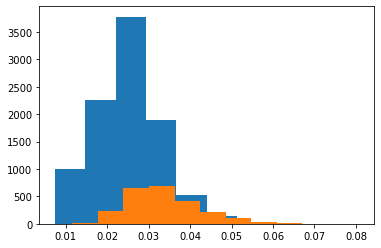

In [100]:
plt.hist(errors_norm);
plt.hist(errors_anomaly);

In [104]:
from sklearn.metrics import roc_curve

y_true = np.concatenate([np.zeros_like(y_val_normal), 
                         np.ones_like(y_val_anomaly)])
errors = np.concatenate([errors_norm, errors_anomaly])

fpr, tpr, thresholds = roc_curve(y_true, errors)
plt.plot(fpr, tpr, color="darkorange")
plt.show()


opt_threshold = thresholds[np.argmax(tpr - fpr)]

In [105]:
from sklearn.metrics import confusion_matrix

def predict_anomaly(model, data, threshold):
    error = compute_reconstruction_error(model, data)
    return (error > threshold).astype(int)




test_normal_pred = predict_anomaly(autoencoder, x_test_normal, opt_threshold)
test_anomaly_pred = predict_anomaly(autoencoder, x_test_anomaly, opt_threshold)

y_true = np.concatenate([np.zeros_like(y_test_normal), 
                         np.ones_like(y_test_anomaly)])

y_predicted = np.concatenate([test_normal_pred, test_anomaly_pred])

conf_matrix = confusion_matrix(y_true, y_predicted)

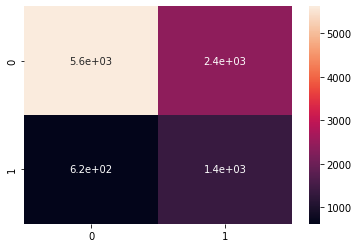

In [106]:
import seaborn as sns

sns.heatmap(conf_matrix, annot=True)